# Comparing the surface with the subsurface maximum in bgc argo data

The data is a synthesis product that comes from here:
https://www.seanoe.org/data/00311/42182/

# guiding question:
Do the BGC argo float data find evidence for a subsurface chl max in the SO *that isn’t visible in surface measurements*?

# answer:
- BGC argo doesn't see the surface. Most of the depth profiles with an available subsurface chl max do not have available measurements shallower than 15m. In the SO, the proportion is about 25%. 
- of the floats in the summer in the SO that do have a valid measurement to compare to, the subsurface chlorophyll max is different from the surface measurement. 


In [186]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [187]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [188]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

### establish regions and import mask

Text(0.5, 0.98, 'check that norm of colours works')

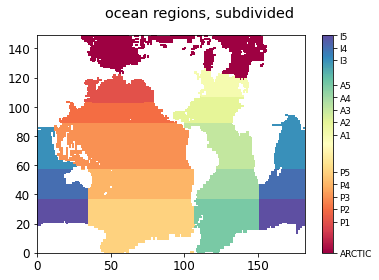

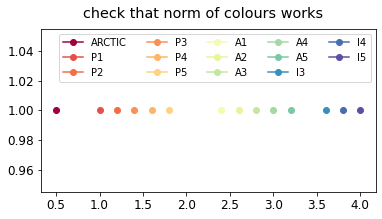

In [189]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics)
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

fact = 0.2
fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
plt.legend(ncol = 5, fontsize = 10)
plt.suptitle('check that norm of colours works')

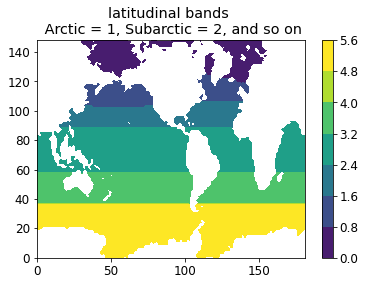

In [190]:
mask_latbands = np.copy(maskno)

mask_latbands[maskno == 0.5] = 0.1
mask_latbands[(maskno == 1) | (maskno == 2.4)] = 1
mask_latbands[(maskno == 1.2) | (maskno == 2.6)] = 2
mask_latbands[(maskno == 1.4) | (maskno == 2.8) | (maskno == 3.6)] = 3
mask_latbands[(maskno == 1.6) | (maskno == 3.0) | (maskno == 3.8)] = 4
mask_latbands[(maskno == 1.8) | (maskno == 3.2) | (maskno == 4.0)] = 5

w = plt.contourf(mask_latbands, vmin = 0, vmax = 5)
plt.title('latitudinal bands \n Arctic = 1, Subarctic = 2, and so on')
plt.colorbar(w)

## primary extraction process description

    - set horse flag to True in cell below to run (horses run)
    - Load individual BGC argo profiles and check if they contain chlA
    - for each profile, get out CHLA_ADJUSTED and CHLA_ADJUSTED_QC
    - look only at CHLA_ADJUSTED where CHLA_ADJUSTED_QC is 1
    - find depth of subsurface chl max, store depth and identity of max
    - also check whether the depth of the SS chlmax is identical to the first measurement (for possibility of discarding later)
    - save table with these data as csv, then concatenate csv on identity of profile (which is float number concatenated with prof. number / 1000)

In [191]:
horse = False

In [192]:
sset = ['coriolis','kma','csiro','bodc', 'nmdis', 'incois', 'aoml', 'meds', 'csio', 'kordi', 'jma']

In [193]:
if horse:
    i = 0
    with_chl = []
    for i in range(0,len(sset)):
        w = glob.glob(f'/gpfs/data/greenocean/observations/202210-BgcArgoSprof/dac/{sset[i]}/*.nc')
        print(len(w))
        for r in range(0,len(w)):
            tw = xr.open_dataset(w[r])
            if 'CHLA' in tw.keys():
                with_chl.append(w[r])
    pickle.dump(with_chl, open("./pkls/BGCwithCHL.pkl", 'wb'))


In [194]:
exhorse = False
verbose = False
if exhorse:

    BGClist = pickle.load(open('./pkls/BGCwithCHL.pkl', 'rb'))

    for i in range(0,len(BGClist)):
        t1 = time.time()
        print(f'{i}: extracting subsurface chlorophyll for {BGClist[i]}')
        w = xr.open_dataset(BGClist[i])
        #print(w)
        tplat = (np.unique(w['PLATFORM_NUMBER']).astype(float))
        tplat = int(tplat[0])
        testnam = f'ChlMaxSurf_{w.institution}_{tplat}.csv'
        print(f'to {testnam}')
        no_profs = (len(w['N_PROF']))

        funct_prof = []
        for k in range(0,no_profs):

            testchl_qc = w['CHLA_ADJUSTED_QC'][k,:].values.astype(float)
            tmin = np.nanmin(testchl_qc)
            if tmin <= 1.0:
                funct_prof.append(k)


        ## save lat, lon, y, x, region of ocean, date, loc of max
        floatno = np.zeros(len(funct_prof))
        lat = np.zeros(len(funct_prof))
        lon = np.zeros(len(funct_prof))
        mon = np.zeros(len(funct_prof))
        day = np.zeros(len(funct_prof))    
        year = np.zeros(len(funct_prof))
        chlmax = np.zeros(len(funct_prof))
        chlmean = np.zeros(len(funct_prof))
        depth_chlmax= np.zeros(len(funct_prof))
        max_below_first_measurement = np.zeros(len(funct_prof))
        max_double_mean = np.zeros(len(funct_prof))

        ### first one
        chl_first_mes = np.zeros(len(funct_prof))
        depth_first_mes= np.zeros(len(funct_prof))

        Y = np.zeros(len(funct_prof))
        X = np.zeros(len(funct_prof))
        
        for k in range(0,len(funct_prof)):

            tp = funct_prof[k]

            testchl = w['CHLA_ADJUSTED'][tp,:].values.astype(float)
            testchl_qc = w['CHLA_ADJUSTED_QC'][tp,:].values.astype(float)
            testpres = w['PRES'][tp,:].values.astype(float)
            filt = (testchl_qc == 1.0)

            foran_chl = testchl[filt]
            foran_pres = testpres[filt]

            chlmax[k] = (np.nanmax(foran_chl)) 
            chlmean[k] = (np.nanmean(foran_chl))#max fluorescence 
            dchlmax = ((np.where(foran_chl == chlmax[k]))[0][0])
            depth_chlmax[k] = foran_pres[dchlmax]
            
            firstmes = (np.nanmin(testpres[filt]))
            depth_first_mes[k] = firstmes
            chl_first_mes[k] = foran_chl[((np.where(foran_pres == firstmes))[0][0])]
            if verbose:
                print(f'first {firstmes}')#depth_first_mes[k])
                print(chl_first_mes[k])

            if depth_chlmax[k] > firstmes:
                max_below_first_measurement[k] = 1
            if chlmax[k] >= 2* chlmean[k]:
                max_double_mean[k] = 1
            
            #place in spacetime, number of float, number of profiles            
            lat[k] = w['LATITUDE'][tp].values.astype(float)
            lon[k] = w['LONGITUDE'][tp].values.astype(float)
            Y[k], X[k] = ut.find_closest(lon[k], lat[k])
            testjuld = pd.to_datetime(w['JULD'][tp].values)
            mon[k] = testjuld.month
            day[k] = testjuld.day
            year[k] = testjuld.year
            floatno[k] = tplat + tp/1000



            if verbose:
                print(f'{lat[k]},{lon[k]},{mon[k]},{day[k]},{year[k]}, maxchl {chlmax[k]}, loc = {depth_chlmax[k]}, float = {floatno[k]}')
                plt.figure()
                plt.plot(testchl,-testpres)
                plt.plot(chlmax[k],-depth_chlmax[k],'r*')

        df = pd.DataFrame([floatno,lat,lon,X,Y,mon,day,year,chl_first_mes,depth_first_mes,chlmax,depth_chlmax,max_below_first_measurement,chlmean,max_double_mean]).T
            # df = df.sort_values(by = tYEAR)
        df.columns = ['profno','lat','lon','X','Y','mon','day','year','chl_first_mes','depth_first_mes','chlmax','depth_chlmax','max_below_first_measurement','chlmean','max_double_mean']
        if i == 1:
            print(df.columns)
        df.wheremade = 'evalOutput/BGC_subsurfacechla.ipynb'
        df.to_csv(f'./argo_processed/{testnam}')

        t2 = time.time()        
        print(t2-t1)
        print()


In [195]:
w = pd.read_csv('./argo_processed/CHLMAX_AOML_1902303.csv')
w.columns

Index(['Unnamed: 0', 'profno', 'lat', 'lon', 'X', 'Y', 'mon', 'day', 'year',
       'chlmax', 'depth_chlmax', 'max_below_first_measurement', 'chlmean',
       'max_double_mean'],
      dtype='object')

## short demo of peak finding alg. on several individual profiles

0: extracting subsurface chlorophyll for /gpfs/data/greenocean/observations/202210-BgcArgoSprof/dac/coriolis/6902907_Sprof.nc
to CHLMAX_CORIOLIS_6902907.csv
-7.989143333333333,-140.47197166666666,1.0,31.0,2019.0, maxchl 0.32850000262260437, loc = 83.5999984741211, float = 6902907.109


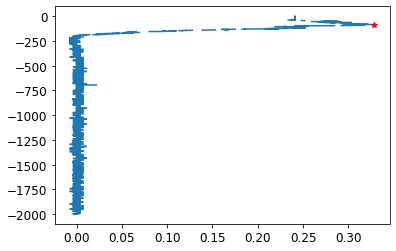

In [196]:
verbose = True


BGClist = pickle.load(open('./pkls/BGCwithCHL.pkl', 'rb'))

for i in range(0,1):#len(BGClist)):
    t1 = time.time()
    print(f'{i}: extracting subsurface chlorophyll for {BGClist[i]}')
    w = xr.open_dataset(BGClist[i])
    #print(w)
    tplat = (np.unique(w['PLATFORM_NUMBER']).astype(float))
    tplat = int(tplat[0])
    testnam = f'CHLMAX_{w.institution}_{tplat}.csv'
    print(f'to {testnam}')
    no_profs = (len(w['N_PROF']))

    funct_prof = []
    for k in range(0,no_profs):

        testchl_qc = w['CHLA_ADJUSTED_QC'][k,:].values.astype(float)
        tmin = np.nanmin(testchl_qc)
        if tmin <= 1.0:
            funct_prof.append(k)


    ## save lat, lon, y, x, region of ocean, date, loc of max
    floatno = np.zeros(len(funct_prof))
    lat = np.zeros(len(funct_prof))
    lon = np.zeros(len(funct_prof))
    mon = np.zeros(len(funct_prof))
    day = np.zeros(len(funct_prof))    
    year = np.zeros(len(funct_prof))
    Y = np.zeros(len(funct_prof))
    X = np.zeros(len(funct_prof))
    chlmax = np.zeros(len(funct_prof))
    depth_chlmax= np.zeros(len(funct_prof))
    max_below_first_measurement = np.zeros(len(funct_prof))

    for k in range(0,1):#len(funct_prof)):

        tp = funct_prof[k]

        testchl = w['CHLA_ADJUSTED'][tp,:].values.astype(float)
        testchl_qc = w['CHLA_ADJUSTED_QC'][tp,:].values.astype(float)
        testpres = w['PRES'][tp,:].values.astype(float)
        filt = (testchl_qc == 1.0)

        foran_chl = testchl[filt]
        foran_pres = testpres[filt]

        chlmax[k] = (np.nanmax(foran_chl)) #max fluorescence 
        dchlmax = ((np.where(foran_chl == chlmax[k]))[0][0])
        depth_chlmax[k] = foran_pres[dchlmax]
        firstmes = (np.nanmin(testpres[filt]))

        if depth_chlmax[k] > firstmes:
            max_below_first_measurement[k] = 1

        #place in spacetime, number of float, number of profiles            
        lat[k] = w['LATITUDE'][tp].values.astype(float)
        lon[k] = w['LONGITUDE'][tp].values.astype(float)
        Y[k], X[k] = ut.find_closest(lon[k], lat[k])
        testjuld = pd.to_datetime(w['JULD'][tp].values)
        mon[k] = testjuld.month
        day[k] = testjuld.day
        year[k] = testjuld.year
        floatno[k] = tplat + tp/1000



        if verbose:
            print(f'{lat[k]},{lon[k]},{mon[k]},{day[k]},{year[k]}, maxchl {chlmax[k]}, loc = {depth_chlmax[k]}, float = {floatno[k]}')
            plt.figure()
            plt.plot(testchl,-testpres)
            plt.plot(chlmax[k],-depth_chlmax[k],'r*')




- concatenate chlorophyll profiles into a single file, called ./argo_processed/concat_chlmax.csv
- find model y, x in findYX_forchlx.py
- concatenate Y,X with the rest of the dataframe, get regions as seen above, save whole thing again

In [197]:
## concatenate chlorophylls 
horse2 = False
if horse2:
    w = glob.glob('./argo_processed/ChlMaxSurf_*')
    df1 = pd.read_csv(w[0])
    df2 = pd.read_csv(w[1])

    # print(df1)
    # print(df2)
    dfs = []
    # df = pd.concat([df1, df2])
    for i in range(0,len(w)):
        dfs.append(pd.read_csv(w[i]))

    masterdf = pd.concat(dfs)
    masterdf.to_csv(f'./argo_processed/concat_ChlMaxSurf.csv')

In [198]:

if horse2:
    masterdf = pd.read_csv('./argo_processed/concat_ChlMaxSurf.csv')
    masterdf.columns
    Y = np.array(masterdf['Y'])
    X = np.array(masterdf['X'])
#     yx1 = pd.read_csv(f'./argo_processed/chl_yx_0_30000.csv')
#     yx2 = pd.read_csv(f'./argo_processed/chl_yx_30000_end.csv')

#     Y = np.zeros_like(lat)
#     X = np.zeros_like(lat)

#     Y[0:30000] = yx1['Y'][0:30000]
#     X[0:30000] = yx1['X'][0:30000]
#     Y[30000:68000] = yx2['Y'][30000:68000]
#     X[30000:68000] = yx2['X'][30000:68000]

#     masterdf['Y'] = Y
#     masterdf['X'] = X
    tREG = np.zeros_like(Y)

    for i in range(0,len(X)):
        tREG[i] = maskno[int(Y[i]), int(X[i])]
    masterdf['REG'] = tREG        
    masterdf.to_csv(f'./argo_processed/concat_ChlMaxSurf.csv')

# cleaned dataset look

In [199]:
chlmax = pd.read_csv(f'./argo_processed/concat_ChlMaxSurf.csv')
chlmax.columns
#chlmax.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'], axis = 1)


Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'profno', 'lat', 'lon',
       'X', 'Y', 'mon', 'day', 'year', 'chl_first_mes', 'depth_first_mes',
       'chlmax', 'depth_chlmax', 'max_below_first_measurement', 'chlmean',
       'max_double_mean', 'REG'],
      dtype='object')

In [200]:
chlmax

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,profno,lat,lon,X,Y,mon,day,year,chl_first_mes,depth_first_mes,chlmax,depth_chlmax,max_below_first_measurement,chlmean,max_double_mean,REG
0,0,0,0,6902549.001,72.660000,1.495000,138.0,129.0,8.0,8.0,2014.0,0.853200,5.090000,1.69920,16.879999,1.0,0.070516,1.0,0.5
1,1,1,1,6902549.003,72.651000,2.587000,138.0,129.0,8.0,27.0,2014.0,0.766800,4.280000,0.88200,26.639999,1.0,0.053904,1.0,0.5
2,2,2,2,6902549.004,72.472000,2.945000,138.0,129.0,9.0,6.0,2014.0,0.669600,5.500000,0.93240,26.690001,1.0,0.076811,1.0,0.5
3,3,3,3,6902549.005,72.629000,3.974000,138.0,129.0,9.0,16.0,2014.0,0.694800,5.540000,0.77760,26.530001,1.0,0.056833,1.0,0.5
4,4,4,4,6902549.006,72.591000,3.870000,138.0,129.0,9.0,26.0,2014.0,0.316800,4.360000,0.42480,36.740002,1.0,0.034007,1.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67892,67892,204,204,6903575.211,71.738612,-7.712557,135.0,128.0,9.0,26.0,2022.0,0.282675,19.790001,0.42300,32.200001,1.0,0.052318,1.0,0.5
67893,67893,205,205,6903575.212,71.733403,-7.718373,135.0,128.0,9.0,26.0,2022.0,0.330000,25.000000,0.47400,31.400000,1.0,0.032425,1.0,0.5
67894,67894,206,206,6903575.213,71.685313,-7.670697,135.0,128.0,10.0,1.0,2022.0,0.374100,18.590000,0.52200,26.600000,1.0,0.040505,1.0,0.5
67895,67895,207,207,6903575.214,71.690290,-7.670925,135.0,128.0,10.0,1.0,2022.0,0.426000,20.900000,0.51000,24.600000,1.0,0.013852,1.0,0.5


In [201]:
djf = ((chlmax['mon']>=12) | (chlmax['mon']<=2))
mam = ((chlmax['mon']>=3) & (chlmax['mon']<=5))
jja = ((chlmax['mon']>=6) & (chlmax['mon']<=8))
son = ((chlmax['mon']>=9) & (chlmax['mon']<=11))

regnumA = regdict['ARCTIC']['number']
regcondA = (chlmax['REG'] ==  regnumA)

regnumP1 = regdict['P1']['number']; regnumA1 = regdict['A1']['number'] 
regcond1 = (chlmax['REG'] ==  regnumP1) | (chlmax['REG'] ==  regnumA1)

regnumP2 = regdict['P2']['number']; regnumA2 = regdict['A2']['number'] 
regcond2 = (chlmax['REG'] ==  regnumP2) | (chlmax['REG'] ==  regnumA2)

regnumP3 = regdict['P3']['number']; regnumA3 = regdict['A3']['number']; regnumI3 = regdict['I3']['number'] 
regcond3 = (chlmax['REG'] ==  regnumP3) | (chlmax['REG'] ==  regnumA3) | (chlmax['REG'] ==  regnumI3)

regnumP4 = regdict['P4']['number']; regnumA4 = regdict['A4']['number']; regnumI4 = regdict['I4']['number'] 
regcond4 = (chlmax['REG'] ==  regnumP4) | (chlmax['REG'] ==  regnumA4) | (chlmax['REG'] ==  regnumI4)

regnumP5 = regdict['P5']['number']; regnumA5 = regdict['A5']['number']; regnumI5 = regdict['I5']['number'] 
regcond5 = (chlmax['REG'] ==  regnumP5) | (chlmax['REG'] ==  regnumA5) | (chlmax['REG'] ==  regnumI5)

shallowChl = chlmax['depth_first_mes'] < 15

In [202]:
regconds = [regcondA, regcond1, regcond2, regcond3, regcond4, regcond5]    

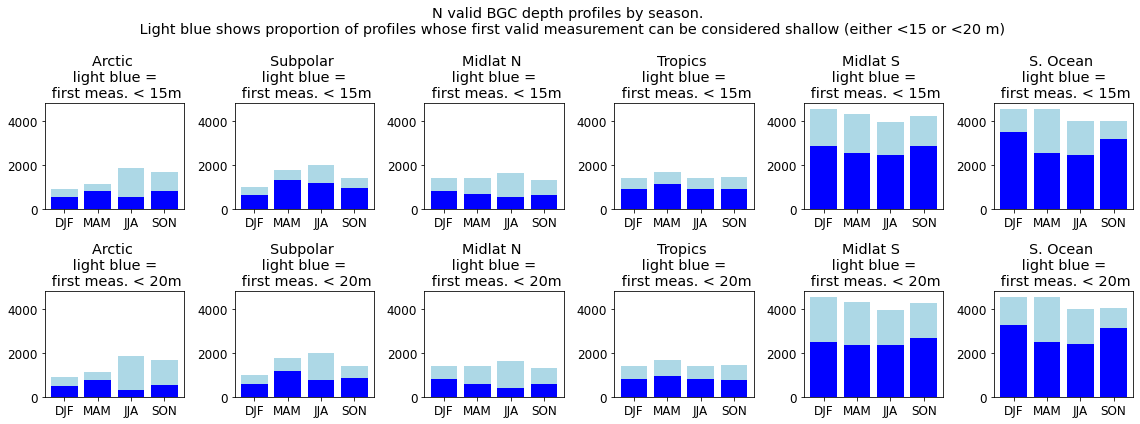

In [203]:
regconds = [regcondA, regcond1, regcond2, regcond3, regcond4, regcond5]    
reglabs = ['Arctic', 'Subpolar', 'Midlat N', 'Tropics', 'Midlat S', 'S. Ocean']
shallowChl = chlmax['depth_first_mes'] < 15
fact = 2
fig, axs = plt.subplots(2,6, figsize=(8*fact, 3*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

shallowChl = chlmax['depth_first_mes'] < 15
for i in range(0,6):
    totmes = (np.size((chlmax.loc[(djf &  regconds[i]),['chlmax']])))
    shalmes = (np.size((chlmax.loc[(djf &  regconds[i] & shallowChl),['chlmax']])))
    axs[i].bar(0, totmes-shalmes, color='b')
    axs[i].bar(0, shalmes, bottom=totmes-shalmes, color='lightblue')
    
    totmes = (np.size((chlmax.loc[(mam &  regconds[i]),['chlmax']])))
    shalmes = (np.size((chlmax.loc[(mam &  regconds[i] & shallowChl),['chlmax']])))
    axs[i].bar(1, totmes-shalmes, color='b')
    axs[i].bar(1, shalmes, bottom=totmes-shalmes, color='lightblue')
    
    totmes = (np.size((chlmax.loc[(jja &  regconds[i]),['chlmax']])))
    shalmes = (np.size((chlmax.loc[(jja &  regconds[i] & shallowChl),['chlmax']])))
    axs[i].bar(2, totmes-shalmes, color='b')
    axs[i].bar(2, shalmes, bottom=totmes-shalmes, color='lightblue')
    
    totmes = (np.size((chlmax.loc[(son &  regconds[i]),['chlmax']])))
    shalmes = (np.size((chlmax.loc[(son &  regconds[i] & shallowChl),['chlmax']])))
    axs[i].bar(3, totmes-shalmes, color='b')
    axs[i].bar(3, shalmes, bottom=totmes-shalmes, color='lightblue')
    
shallowChl = chlmax['depth_first_mes'] < 20
for i in range(6,12):
    totmes = (np.size((chlmax.loc[(djf &  regconds[i-6]),['chlmax']])))
    shalmes = (np.size((chlmax.loc[(djf &  regconds[i-6] & shallowChl),['chlmax']])))
    axs[i].bar(0, totmes-shalmes, color='b')
    axs[i].bar(0, shalmes, bottom=totmes-shalmes, color='lightblue')
    
    totmes = (np.size((chlmax.loc[(mam &  regconds[i-6]),['chlmax']])))
    shalmes = (np.size((chlmax.loc[(mam &  regconds[i-6] & shallowChl),['chlmax']])))
    axs[i].bar(1, totmes-shalmes, color='b')
    axs[i].bar(1, shalmes, bottom=totmes-shalmes, color='lightblue')
    
    totmes = (np.size((chlmax.loc[(jja &  regconds[i-6]),['chlmax']])))
    shalmes = (np.size((chlmax.loc[(jja &  regconds[i-6] & shallowChl),['chlmax']])))
    axs[i].bar(2, totmes-shalmes, color='b')
    axs[i].bar(2, shalmes, bottom=totmes-shalmes, color='lightblue')
    
    totmes = (np.size((chlmax.loc[(son &  regconds[i-6]),['chlmax']])))
    shalmes = (np.size((chlmax.loc[(son &  regconds[i-6] & shallowChl),['chlmax']])))
    axs[i].bar(3, totmes-shalmes, color='b')
    axs[i].bar(3, shalmes, bottom=totmes-shalmes, color='lightblue')

    

for i in range(0,12):
    axs[i].set_xticks([0,1,2,3])
    axs[i].set_xticklabels(['DJF','MAM','JJA','SON'])
   
    axs[i].set_ylim([0,4800])
for i in range(0,6):
    axs[i].set_title(f'{reglabs[i]} \n light blue = \n first meas. < 15m')
for i in range(6,12):    
     axs[i].set_title(f'{reglabs[i-6]} \n light blue = \n first meas. < 20m')


plt.suptitle('N valid BGC depth profiles by season. \n Light blue shows proportion of profiles whose first valid measurement can be considered shallow (either <15 or <20 m)')

plt.tight_layout()

# let's try to look at the ratio between the first measurement and the maximum. 

- here I am only considering depth profiles whose first measurement is shallower than 15m. 

It turns out it is not very helpful to look the obtained values this way, because if the first measurement is near-0 and the subsurface maximum is some reasonable value, the ratio between them can blow up.

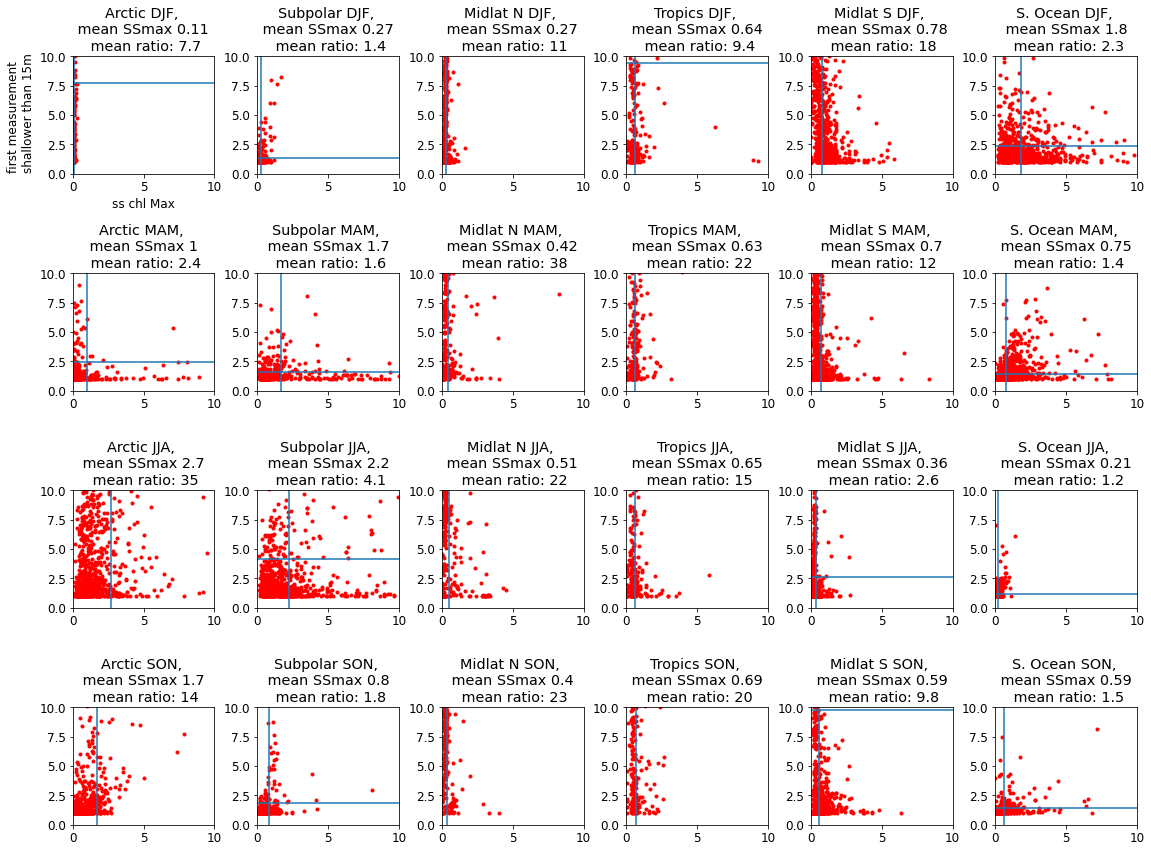

In [204]:
poschl = ((chlmax['chl_first_mes'] > 0) & (chlmax['chlmax'] > 0))
shallowChl = chlmax['depth_first_mes'] < 15

fact = 2
fig, axs = plt.subplots(4,6, figsize=(8*fact, 6*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,6):
    chl_1 = np.array(chlmax.loc[(poschl & djf &  regconds[i] & shallowChl),['chl_first_mes']])
    chl_max = np.array(chlmax.loc[poschl & (djf &  regconds[i] & shallowChl),['chlmax']])
    rat = chl_max/chl_1
    axs[i].plot(chl_max, rat, 'r.')
    axs[i].axhline(np.nanmean(rat), label = 'mean ratio between ss chlmax & first measurement')
    axs[i].axvline(np.nanmean(chl_max), label = 'mean ss chlmax')
    rat_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(rat))))
    chlmax_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(chl_max))))
    axs[i].set_title(f'{reglabs[i]} DJF, \n mean SSmax {chlmax_sf} \n mean ratio: {rat_sf}')
    
for i in range(6,12):
    w = i-6
    chl_1 = np.array(chlmax.loc[(poschl & mam &  regconds[w] & shallowChl),['chl_first_mes']])
    chl_max = np.array(chlmax.loc[poschl & (mam &  regconds[w] & shallowChl),['chlmax']])
    rat = chl_max/chl_1
    axs[i].plot(chl_max, rat, 'r.')
    axs[i].axhline(np.nanmean(rat), label = 'mean ratio between ss chlmax & first measurement')
    axs[i].axvline(np.nanmean(chl_max), label = 'mean ss chlmax')
    rat_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(rat))))
    chlmax_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(chl_max))))
    axs[i].set_title(f'{reglabs[w]} MAM, \n mean SSmax {chlmax_sf} \n mean ratio: {rat_sf}')
    
for i in range(12,18):
    w = i-12
    chl_1 = np.array(chlmax.loc[(poschl & jja &  regconds[w] & shallowChl),['chl_first_mes']])
    chl_max = np.array(chlmax.loc[poschl & (jja &  regconds[w] & shallowChl),['chlmax']])
    rat = chl_max/chl_1
    axs[i].plot(chl_max, rat, 'r.')
    axs[i].axhline(np.nanmean(rat), label = 'mean ratio between ss chlmax & first measurement')
    axs[i].axvline(np.nanmean(chl_max), label = 'mean ss chlmax')
    rat_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(rat))))
    chlmax_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(chl_max))))
    axs[i].set_title(f'{reglabs[w]} JJA, \n mean SSmax {chlmax_sf} \n mean ratio: {rat_sf}')  
    
for i in range(18,24):
    w = i-18
    chl_1 = np.array(chlmax.loc[(poschl & son &  regconds[w] & shallowChl),['chl_first_mes']])
    chl_max = np.array(chlmax.loc[poschl & (son &  regconds[w] & shallowChl),['chlmax']])
    rat = chl_max/chl_1
    axs[i].plot(chl_max, rat, 'r.')
    axs[i].axhline(np.nanmean(rat), label = 'mean ratio between ss chlmax & first measurement')
    axs[i].axvline(np.nanmean(chl_max), label = 'mean ss chlmax')
    rat_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(rat))))
    chlmax_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(chl_max))))
    axs[i].set_title(f'{reglabs[w]} SON, \n mean SSmax {chlmax_sf} \n mean ratio: {rat_sf}')  

axs[0].set_xlabel('ss chl Max')
axs[0].set_ylabel('first measurement \n shallower than 15m')
for i in range(0,24):

    axs[i].set_xlim([0,10])
    axs[i].set_ylim([0,10])
plt.tight_layout()

# Maybe let's look at the *gain* (in absolute values) between maximum and first measurement

Looking at the values for the SO, the subsurface chlorophyll max isn't very "hidden" - on average

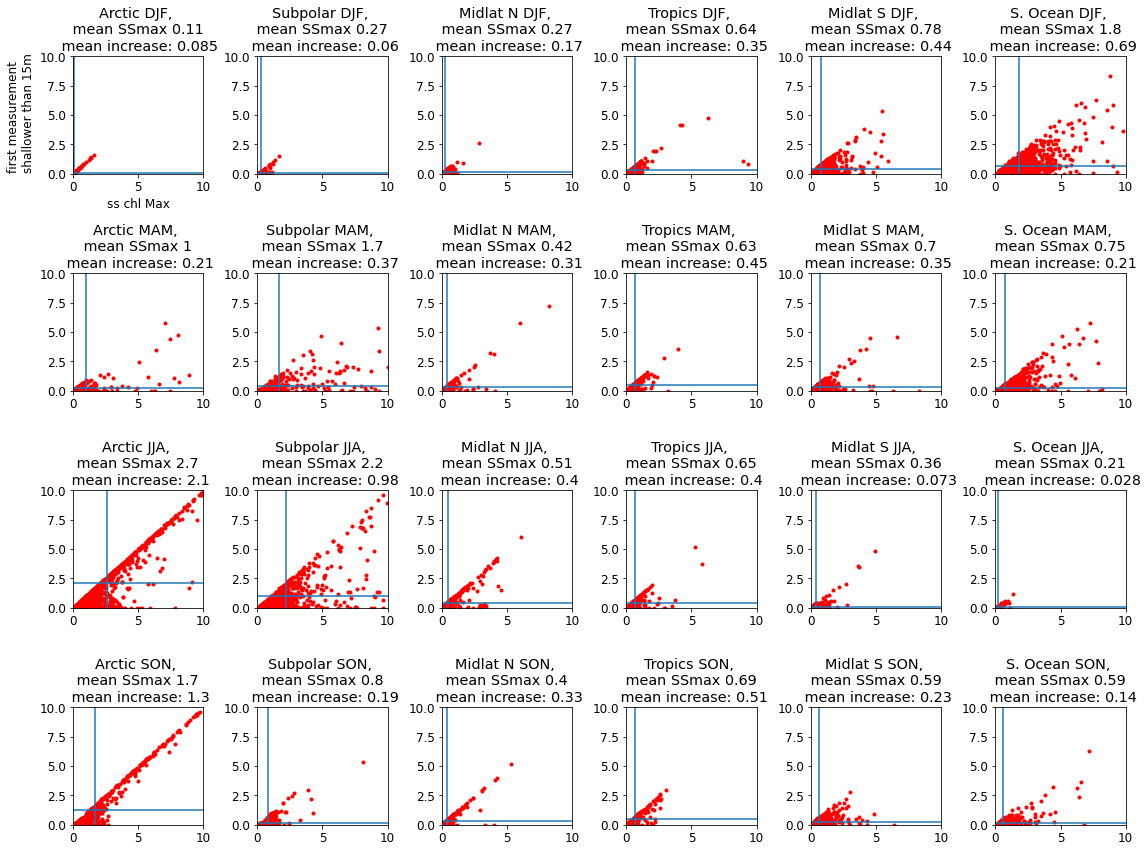

In [205]:
poschl = ((chlmax['chl_first_mes'] > 0) & (chlmax['chlmax'] > 0))
shallowChl = chlmax['depth_first_mes'] < 15

fact = 2
fig, axs = plt.subplots(4,6, figsize=(8*fact, 6*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,6):
    chl_1 = np.array(chlmax.loc[(poschl & djf &  regconds[i] & shallowChl),['chl_first_mes']])
    chl_max = np.array(chlmax.loc[poschl & (djf &  regconds[i] & shallowChl),['chlmax']])
    rat = chl_max-chl_1
    axs[i].plot(chl_max, rat, 'r.')
    axs[i].axhline(np.nanmean(rat), label = 'mean ratio between ss chlmax & first measurement')
    axs[i].axvline(np.nanmean(chl_max), label = 'mean ss chlmax')
    rat_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(rat))))
    chlmax_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(chl_max))))
    axs[i].set_title(f'{reglabs[i]} DJF, \n mean SSmax {chlmax_sf} \n mean increase: {rat_sf}')
    
for i in range(6,12):
    w = i-6
    chl_1 = np.array(chlmax.loc[(poschl & mam &  regconds[w] & shallowChl),['chl_first_mes']])
    chl_max = np.array(chlmax.loc[poschl & (mam &  regconds[w] & shallowChl),['chlmax']])
    rat = chl_max-chl_1
    axs[i].plot(chl_max, rat, 'r.')
    axs[i].axhline(np.nanmean(rat), label = 'mean ratio between ss chlmax & first measurement')
    axs[i].axvline(np.nanmean(chl_max), label = 'mean ss chlmax')
    rat_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(rat))))
    chlmax_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(chl_max))))
    axs[i].set_title(f'{reglabs[w]} MAM, \n mean SSmax {chlmax_sf} \n mean increase: {rat_sf}')
    
for i in range(12,18):
    w = i-12
    chl_1 = np.array(chlmax.loc[(poschl & jja &  regconds[w] & shallowChl),['chl_first_mes']])
    chl_max = np.array(chlmax.loc[poschl & (jja &  regconds[w] & shallowChl),['chlmax']])
    rat = chl_max-chl_1
    axs[i].plot(chl_max, rat, 'r.')
    axs[i].axhline(np.nanmean(rat), label = 'mean ratio between ss chlmax & first measurement')
    axs[i].axvline(np.nanmean(chl_max), label = 'mean ss chlmax')
    rat_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(rat))))
    chlmax_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(chl_max))))
    axs[i].set_title(f'{reglabs[w]} JJA, \n mean SSmax {chlmax_sf} \n mean increase: {rat_sf}')  
    
for i in range(18,24):
    w = i-18
    chl_1 = np.array(chlmax.loc[(poschl & son &  regconds[w] & shallowChl),['chl_first_mes']])
    chl_max = np.array(chlmax.loc[poschl & (son &  regconds[w] & shallowChl),['chlmax']])
    rat = chl_max-chl_1
    axs[i].plot(chl_max, rat, 'r.')
    axs[i].axhline(np.nanmean(rat), label = 'mean ratio between ss chlmax & first measurement')
    axs[i].axvline(np.nanmean(chl_max), label = 'mean ss chlmax')
    rat_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(rat))))
    chlmax_sf = '{:g}'.format(float('{:.2g}'.format(np.nanmean(chl_max))))
    axs[i].set_title(f'{reglabs[w]} SON, \n mean SSmax {chlmax_sf} \n mean increase: {rat_sf}')  

axs[0].set_xlabel('ss chl Max')
axs[0].set_ylabel('first measurement \n shallower than 15m')

for i in range(0,24):

    axs[i].set_xlim([0,10])
    axs[i].set_ylim([0,10])
plt.tight_layout()

plt.tight_layout()